In [1]:
from heapq import heappush, heappop
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# https://github.com/bstabler/TransportationNetworks/tree/master/SiouxFalls
# 42.31335287107440

In [2]:

def read_network_data(filename):
    net = pd.read_csv(filename, skiprows=8, sep='\t')
    trimmed= [s.strip().lower() for s in net.columns]
    net.columns = trimmed
    # And drop the silly first andlast columns
    net.drop(['~', ';'], axis=1, inplace=True)
    return net

def read_trip_data(filename):
    f = open(filename, 'r')
    all_rows = f.read()
    blocks = all_rows.split('Origin')[1:]
    trip = {}
    for k in range(len(blocks)):
        orig = blocks[k].split('\n')
        dests = orig[1:]
        orig=int(orig[0])

        d = [eval('{'+a.replace(';',',').replace(' ','') +'}') for a in dests]
        destinations = {}
        for i in d:
            destinations = {**destinations, **i}
        trip[orig] = destinations
    return trip

def create_graph(net):

    Nodes = {}
    Links = {}
    Nodes_Links = {}
    
    for l in net.index:
        from_node = net.loc[l, 'init_node']
        to_node   = net.loc[l, 'term_node']
        cost = net.loc[l, 'free_flow_time']
        capacity = net.loc[l, 'capacity']
        length   = net.loc[l, 'length']
        fft      = net.loc[l, 'free_flow_time']
        alpha    = net.loc[l, 'b']
        beta     = net.loc[l, 'power']
        
        Links[l] = {}
        Links[l]['from_node'] = from_node
        Links[l]['to_node'] = to_node
        Links[l]['capacity'] = capacity
        Links[l]['length'] = length
        Links[l]['fft']    = fft
        Links[l]['alpha']  = alpha
        Links[l]['beta']   = beta
        
        Links[l]['flow'] = 0.0
        
        
        Nodes_Links[(from_node, to_node)] = l
        
        
        if Nodes.get(from_node):
            Nodes[from_node]['out_link_list'] = Nodes[from_node]['out_link_list'] + [l]
        else:
            Nodes[from_node] = {}
            Nodes[from_node]['idx'] = from_node
            Nodes[from_node]['out_link_list'] = [l]
            Nodes[from_node]['in_link_list'] = []
            Nodes[from_node]['spl'] = float('inf')
            Nodes[from_node]['flag'] = 1
            Nodes[from_node]['previous_node'] = None
            Nodes[from_node]['previous_link'] = None
            
            
            
        if Nodes.get(to_node):
            Nodes[to_node]['in_link_list'] = Nodes[from_node]['in_link_list'] + [l]
        else:
            Nodes[to_node] = {}
            Nodes[to_node]['idx'] = to_node
            Nodes[to_node]['out_link_list'] = []
            Nodes[to_node]['in_link_list'] = [l]
            Nodes[to_node]['spl'] = float('inf')
            Nodes[to_node]['flag'] = 1
            Nodes[to_node]['previous_node'] = None
            Nodes[to_node]['previous_link'] = None
            
    return Links, Nodes, Nodes_Links


def reset(Nodes):
    for node, data in Nodes.items():
        Nodes[node]['spl'] = float('inf')
        Nodes[node]['flag'] = 1
        Nodes[node]['previous_node'] = None
        Nodes[node]['previous_link'] = None
    return Nodes

def dijkstra(Links, Nodes, cost_arr, source):
    hq = [(0, source)] # (distance, node)
    Nodes[source]['spl'] = 0
    Nodes[source]['flag'] = 0 # 探索済に変更
    
    while hq:
        pivot_node = heappop(hq)[1] #ヒープの先頭を取得
         
        for l in Nodes[pivot_node]['out_link_list']:
            to_node = Links[l]['to_node']
            tmp_cost = Nodes[pivot_node]['spl'] + cost_arr[l]
            
            if tmp_cost < Nodes[to_node]['spl']*float(Nodes[to_node]['flag']):
                Nodes[to_node]['spl'] = tmp_cost
                Nodes[to_node]['previous_node'] = pivot_node
                Nodes[to_node]['previous_link'] = l
                heappush(hq, (tmp_cost, to_node)) #ヒープに追加
                
        Nodes[pivot_node]['flag'] = 0 #探索済に変更 
        
    return Nodes

def update_link_cost(prm, flow_arr):
    func = np.vectorize(lambda fft, capacity, alpha, beta, flow: fft*(1.0 + alpha*(flow/capacity)**(beta)))
    cost_arr = func(prm.fft_arr, prm.capacity_arr, prm.alpha_arr, prm.beta_arr, flow_arr)
    return cost_arr

class Parameter:
    def __init__(self, Links):
        self.fft_arr   = np.array([link['fft'] for link in Links.values()])
        self.capacity_arr   = np.array([link['capacity'] for link in Links.values()])
        self.alpha_arr = np.array([link['alpha'] for link in Links.values()]) 
        self.beta_arr  = np.array([link['beta'] for link in Links.values()])
        
def summing_flow(prm, flow_arr, Nodes, source, trips):
    destination_list = list(trips[source].keys())
    
    for destination in destination_list:
        tr_node = destination
        demand  = trips[source][tr_node]
        while tr_node != source:
            link_idx = Nodes[tr_node]['previous_link']
            flow_arr[link_idx] = flow_arr[link_idx] + demand
            tr_node = Nodes[tr_node]['previous_node']
    return flow_arr

def Z(prm, flow_arr):
    func = np.vectorize(lambda fft, capacity, alpha, beta, flow: fft*(flow + (alpha/(beta+1.0))*(flow)*((flow/capacity)**(beta))))
    return func(prm.fft_arr, prm.capacity_arr, prm.alpha_arr, prm.beta_arr, flow_arr).sum()
        
    
def armijo_rule(old_flow_arr, new_flow_arr, cost_arr_old, armijo_alpha=1.0, armijo_beta=0.5, armijo_epsilon=1e-4):
    """
    Armijo's rule for step size determination.

    Parameters:
    - Z: Objective function
    - x_now: Current solution
    - direction: Search direction
    - armijo_alpha: Initial step size (default: 1.0)
    - armijo_beta: Reduction factor for step size (default: 0.5)
    - armijo_epsilon: Tolerance for the Armijo condition (default: 1e-4)

    Returns:
    - step_size: Computed step size
    """

    # Armijo condition parameters
    c1 = 0.01  # Armijo condition parameter (0 < c1 < 0.5)

    # Compute the initial function value and gradient
    Z_old = Z(prm, old_flow_arr)
    grad_old = cost_arr_old
    
    direction =  new_flow_arr - old_flow_arr

    step_size = armijo_alpha
    while Z(prm, old_flow_arr + step_size * direction) > Z_old + c1 * step_size * (grad_old@direction):
        step_size *= armijo_beta

    return step_size

In [14]:
city_name = 'SiouxFalls'
filename = 'data/' + city_name + '_net.tntp'
net = read_network_data(filename)
filename = 'data/' + city_name + '_trips.tntp'
trips = read_trip_data(filename)

Links, Nodes, Nodes_Links = create_graph(net)
prm = Parameter(Links)
L = len(Links)

# make initial flow_arr
flow_arr = np.zeros(L)
cost_arr = update_link_cost(prm, flow_arr)
origin_list = list(trips.keys())

for source in origin_list:
    Nodes = dijkstra(Links, Nodes, cost_arr, source)
    flow_arr = summing_flow(prm, flow_arr, Nodes, source, trips)
    Nodes = reset(Nodes)

In [15]:
# standard FW
Z_list = [Z(prm, flow_arr)]
for loop in range(100):
    cost_arr = update_link_cost(prm, flow_arr)
    
    new_flow_arr = np.zeros(L)
    for source in origin_list:
        Nodes = dijkstra(Links, Nodes, cost_arr, source)
        new_flow_arr = summing_flow(prm, new_flow_arr, Nodes, source, trips)
        
        Nodes = reset(Nodes)
        
    a = armijo_rule(flow_arr, new_flow_arr, cost_arr, armijo_alpha=1.0, armijo_beta=0.5, armijo_epsilon=1e-4)
    
    flow_arr = (1.0-a)*flow_arr+a*new_flow_arr
    Z_list = Z_list + [Z(prm, flow_arr)]
    print('loop %i: Z ='%loop, Z_list[-1])

loop 0: Z = 7594149.242032827
loop 1: Z = 6670777.354353534
loop 2: Z = 5949101.026319051
loop 3: Z = 5780057.728446648
loop 4: Z = 5260371.489630005
loop 5: Z = 5224495.044155695
loop 6: Z = 5135522.096488971
loop 7: Z = 4915261.223315006
loop 8: Z = 4861337.665289011
loop 9: Z = 4692893.767320562
loop 10: Z = 4593117.694657524
loop 11: Z = 4558164.469942448
loop 12: Z = 4533185.134927208
loop 13: Z = 4494399.379199169
loop 14: Z = 4486734.362105924
loop 15: Z = 4438805.9041631315
loop 16: Z = 4422465.515602105
loop 17: Z = 4410950.976121806
loop 18: Z = 4404056.392360017
loop 19: Z = 4370170.2681373665
loop 20: Z = 4356486.6899554515
loop 21: Z = 4336822.481942768
loop 22: Z = 4328498.387321411
loop 23: Z = 4317707.340254199
loop 24: Z = 4306560.86115722
loop 25: Z = 4302742.049843032
loop 26: Z = 4289985.277692524
loop 27: Z = 4282194.690055559
loop 28: Z = 4276926.444349331
loop 29: Z = 4276267.369288392
loop 30: Z = 4271551.616077508
loop 31: Z = 4271154.881311882
loop 32: Z = 426

In [17]:
(Z_list[98] - Z_list[99])/Z_list[99]

1.8746893745949654e-05

In [16]:
flow_arr

array([ 4518.36786692,  8115.34068334,  4519.7621861 ,  5985.80731979,
        8113.94636416, 14144.16414231, 10219.965124  , 14230.41156024,
       18143.64603169,  5332.78420965, 18236.27283301,  8710.51801964,
       15903.99024327,  5987.20163897,  8806.15165933, 12434.84924342,
       12199.6304232 , 15742.395285  , 12531.87720229, 12092.23199318,
        6885.39357405,  8338.22599924, 15900.98340491,  6893.80408087,
       21760.56932822, 21865.97299666, 17698.98304631, 23129.96105097,
       11045.2654264 ,  8101.20045799,  5426.40482626, 17639.68194841,
        8366.28502929,  9794.67229425, 10132.32338689,  8432.01217129,
       12523.49467091, 12601.58007579, 11100.4640865 ,  9863.26467097,
        9030.31965516,  8351.46198752, 23164.6385939 ,  9088.49629149,
       19075.66634705, 18322.27387133,  8319.44502128, 11075.33404448,
       11616.48252443, 15329.36299357,  8101.15906333, 11602.10668081,
        9927.60047913, 15849.79371501, 15355.02647731, 19076.02671094,
      

In [12]:
cost_arr

array([1.15291987, 1.30777283, 1.17669383, 1.63802264, 1.09157479,
       1.13709607, 1.15514556, 1.00004796, 1.00073109, 1.0000762 ,
       1.00000002, 1.        , 1.00000983, 1.00001002, 1.        ,
       1.00000004, 1.00000485, 1.00000068, 1.00003116, 1.00427169,
       1.00003159, 1.00004824, 1.00000173, 1.00001135, 1.00058075,
       1.00049582, 1.00000349, 1.00030779, 1.00094786, 0.14988333,
       0.149344  , 0.1502545 , 0.14964517, 0.14942932, 0.14907194,
       0.14910414, 0.14914649, 0.14914072, 0.1492678 , 0.15170013,
       0.15275715, 0.14911597, 0.14913706, 0.14924792, 0.14922423,
       0.1491199 , 0.14907282, 0.15183434, 0.15065932, 0.14928283,
       0.14909613, 0.14910762, 0.14907583, 0.14921696, 0.14931671,
       0.15039788, 0.14907857, 0.1500278 , 0.1491881 , 1.45984848,
       1.45984848, 1.32007576, 1.32007576, 1.        , 1.        ,
       1.        , 1.        , 1.54015152, 1.54015152, 1.        ,
       3.        , 1.        , 1.        , 1.        , 1.     

In [523]:
flow_arr

array([ 4878.3996582 ,  8328.97796631,  4773.54278564,  5794.97375488,
        8433.83483887, 17924.06768799, 18245.11108398, 18910.36071777,
       18724.00360107,  7566.56188965, 19892.23175049,  8477.97851562,
       15862.40997314,  5690.11688232,  9048.28948975, 12347.84851074,
       12574.90997314, 15760.81085205, 12813.3026123 , 12322.37091064,
        6563.46740723,  8642.06695557, 16460.32714844,  6436.16333008,
       23098.94561768, 23669.55871582, 16838.19274902, 22279.35791016,
       11005.29785156,  7941.76940918,  7484.62677002, 17153.79638672,
        7673.33831787, 10553.27301025, 17363.67492676,  7627.15606689,
       16820.39489746, 15992.77648926, 12612.82806396, 10933.1237793 ,
        9475.40588379, 10056.41479492, 22254.82177734, 10175.28381348,
       17581.80389404, 19148.58703613,  8982.28607178, 11406.41326904,
       11753.31573486, 18454.95910645,  7720.19958496, 11537.38861084,
       10657.8414917 , 16013.34991455, 19412.22076416, 20229.10461426,
      

In [524]:
# https://www.jstor.org/stable/pdf/25768406.pdf?casa_token=MtbsEEK4TnMAAAAA:_vNVkh93SV5nw1UUxc0tVVlv99GLL15iJLKSKNrcYTgWqGMivZkfKj-TQu7seUkm4L20URjaY-UebrZZLnYf2vT9K_UYhNaBfcwHADxjNDaiwoIiJNrp
# with PARTAN ?
Z_list = [Z(prm, flow_arr)]
flow_arr_hist = {}
flow_arr_hist[-1] = flow_arr

for loop in range(10):
    cost_arr = update_link_cost(prm, flow_arr)
    
    new_flow_arr = np.zeros(L)
    for source in origin_list:
        Nodes = dijkstra(Links, Nodes, cost_arr, source)
        new_flow_arr = summing_flow(prm, new_flow_arr, Nodes, source, trips)
        
        Nodes = reset(Nodes)
        
    a = armijo_rule(flow_arr, new_flow_arr, cost_arr, armijo_alpha=1.0, armijo_beta=0.5, armijo_epsilon=1e-4)
    flow_arr = (1.0-a)*flow_arr + a*new_flow_arr
    
    if loop>0:
        
        a_list = np.linspace(-1.0, 1.0, 1001)
        Z_list = np.array([Z(prm, (1.0-a)*flow_arr + a*flow_arr_hist[loop-2]) for a in a_list])
        a = a_list[Z_list.argmin()]
        print(a)
        flow_arr = (1.0-a)*flow_arr + a*flow_arr_hist[loop-2]
    
    flow_arr_hist[loop] = flow_arr
    
    Z_list = Z_list + [Z(prm, flow_arr)]
    print('loop %i: Z ='%loop, Z_list[-1])
    print('--')

loop 0: Z = 4593117.694657524
--
-0.492
loop 1: Z = 9235661.333601972
--
-0.18999999999999995
loop 2: Z = 9101361.631256476
--
0.20799999999999996
loop 3: Z = 9010530.638002789
--
0.3700000000000001
loop 4: Z = 8940329.418102534
--
-1.0
loop 5: Z = 8835884.385296244
--
-0.18799999999999994
loop 6: Z = 8787617.768130047
--
0.19199999999999995
loop 7: Z = 8711258.326519378
--
-0.758
loop 8: Z = 8681093.292368539
--
-0.914
loop 9: Z = 8649850.263679827
--


In [503]:
flow_arr

array([ 5176.80147716,  8279.31534899,  4535.68012741,  6363.41249435,
        8920.43669874, 14781.10840155, 11899.3290831 , 15573.7671798 ,
       17882.62772462,  6905.09721424, 18619.55596953,  8062.75955715,
       15820.86037029,  5722.2911446 ,  8489.97716967, 12525.20107884,
       12489.52991517, 16369.15271952, 12311.29734161, 13249.31264548,
        7226.37696168,  7605.8884991 , 16130.57100268,  7034.15100084,
       22079.24654823, 22296.73121978, 17607.89247229, 21733.73527196,
       10192.66845767,  9102.01174768,  7060.82774757, 16825.46855389,
        8301.16572622, 10739.1617194 , 11747.79165461,  8280.06615187,
       14020.59469881, 13947.95769597, 10898.77408997, 10233.56790868,
       10239.55628101,  8682.51719581, 22435.39542269,  9727.79345614,
       18166.06344769, 17411.658335  ,  8343.99345302, 10941.42034485,
       11193.83809699, 19226.10127444,  8551.50829972, 11753.62841   ,
       10064.74711835, 15609.36998922, 20153.16780253, 21177.82232098,
      

In [460]:
flow_arr

array([ 4498.42785935,  8116.47103055,  4517.90752146,  5969.53274276,
        8096.99136844, 14074.80170961, 10069.72674158, 14079.95022579,
       18074.63338196,  5243.13992791, 18081.85447996,  8796.29742564,
       15818.06410909,  5989.01240486,  8800.53395904, 12496.662705  ,
       12093.13515797, 15793.05007897, 12520.37890051, 12038.33761361,
        6872.2986725 ,  8380.10978573, 15821.04867369,  6821.19838025,
       21780.74584037, 21832.63011272, 17739.37069104, 23128.02143146,
       11049.03720436,  8100.39001378,  5341.06734608, 17582.23626339,
        8377.52772708,  9794.76291036, 10045.0985633 ,  8398.44504021,
       12359.35474632, 12455.64388117, 11109.99773855,  9814.63858776,
        9039.39196975,  8391.14831351, 23213.98177086,  9075.53951921,
       19084.72317775, 18370.70665283,  8400.12872913, 11072.10901356,
       11658.41243689, 15282.78367551,  8100.37656517, 11654.52658095,
        9942.76507346, 15847.84762333, 15329.76028405, 19037.17765293,
      

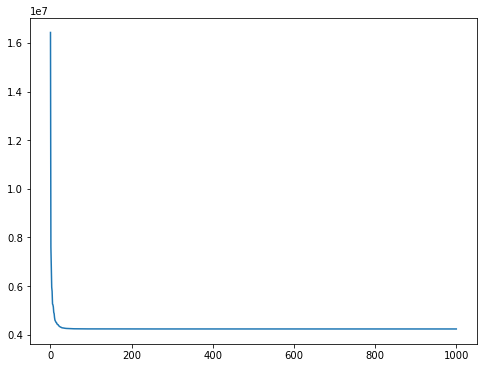

In [532]:
plt.figure(figsize=(8, 6))
plt.plot(Z_list)
# plt.yscale('log')

In [315]:
cost_arr

array([ 6.00084441,  4.00873704,  6.00084546,  6.60309479,  4.00873095,
        4.28147616,  4.02195722,  4.28760848,  2.32629085,  7.25555052,
        2.33229601,  9.94568903,  9.72787184,  6.60461037,  9.91224273,
       14.79291385,  5.64553969,  2.0615011 , 14.74818709,  5.55224759,
       15.29301077, 10.56465394,  9.84271384, 14.95838551,  5.70295389,
        5.74451598, 12.44975398, 13.72220656, 19.91263844, 16.31302161,
        7.3459306 , 12.17662515, 13.55165958, 13.90472837,  4.02129623,
       13.75491875,  3.0246385 ,  3.02525572, 17.55091846, 13.79577285,
       12.46327498,  8.9827607 , 13.8850201 , 12.22289439,  4.32972518,
        8.95899612, 10.54338741, 20.07136003,  9.31066256,  3.16458496,
       16.312849  ,  9.25013138,  7.38913401,  2.06322325,  3.16646551,
        4.26297156,  4.33537649,  7.33686243,  9.48488346,  4.26589112,
        9.47502125,  8.16999371,  7.7386871 ,  8.11397134,  4.21966692,
       11.78155795,  8.86383432,  7.72282207,  4.22197105, 12.15